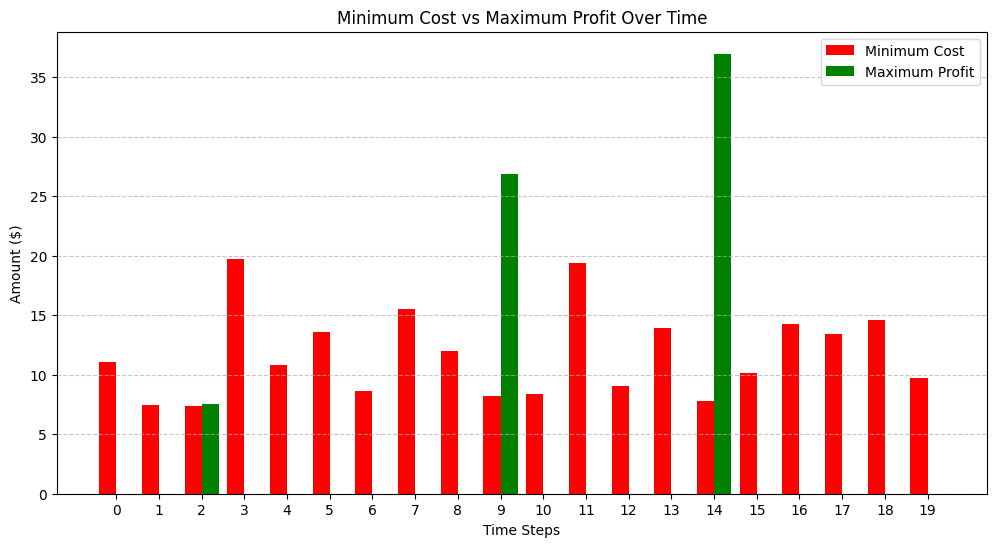

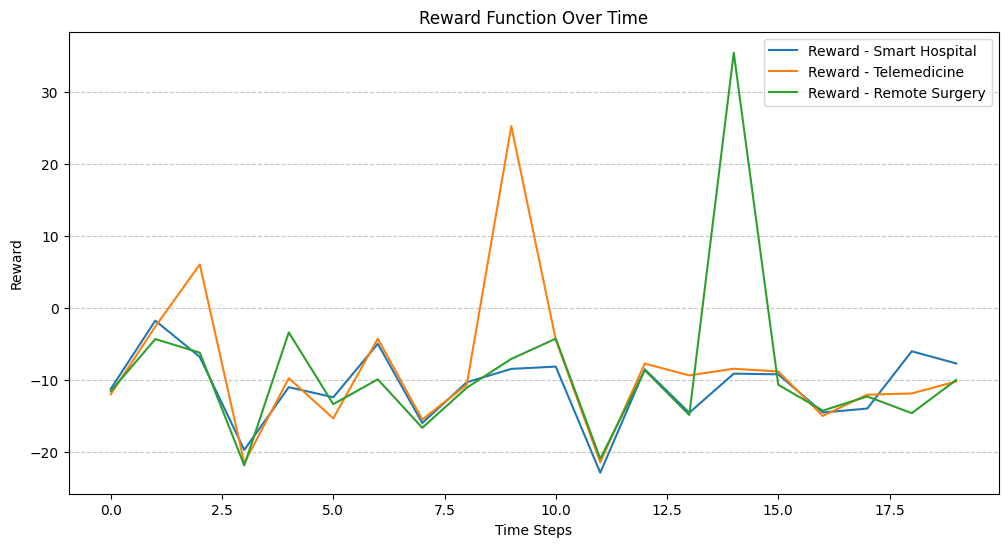

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Environment parameters
N = 3  # Smart Hospital, Telemedicine, Remote Surgery
T = 20  # Reduced for better visualization
slices = ['Smart Hospital', 'Telemedicine', 'Remote Surgery']

# U1 Formula (Total Cost Aggregation)
def compute_U1(S_fp, c_n_v, c_n_k, A_n_fk, c_ij):
    return np.sum(S_fp * (np.sum(c_n_v) + np.sum(c_n_k * A_n_fk))) + np.sum(c_ij)

# Neural Networks for MADDPG
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))  # Continuous action space

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Q-value

# Device configuration
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize agents
actors = [Actor(4, 1).to(dev) for _ in range(N)]
critics = [Critic(5).to(dev) for _ in range(N)]  # 4 state inputs + 1 action

actor_optimizers = [optim.Adam(actor.parameters(), lr=0.001) for actor in actors]
critic_optimizers = [optim.Adam(critic.parameters(), lr=0.002) for critic in critics]

# Initialize total cost, profit, and reward arrays
total_costs = np.zeros(T)
total_profits = np.zeros(T)
reward_values = np.zeros((N, T))  # Store rewards for each agent

gamma = 0.99  # Discount factor
tau = 0.01  # Soft update rate

def select_action(state, actor):
    state = torch.tensor(state, dtype=torch.float32).to(dev)
    with torch.no_grad():
        action = actor(state).cpu().numpy()
    return np.clip(action, 0, 1)  # Action within valid range

min_costs = np.full(T, np.inf)
max_profits = np.zeros(T)

for t in range(T):
    A_n = np.random.rand(N)  # Resource consumption
    M_n = np.random.rand(N)  # Price per unit resource
    C_l = np.random.rand(N)  # Link capacity
    M_l = np.random.rand(N)  # Price per unit link
    B_f = np.random.rand(N)  # QoS weight
    D_f = np.random.rand(N)  # Latency constraint
    H_f = np.random.rand(N)  # Reliability requirement
    A_demand = np.random.rand(N)  # Resource demand
    A_capacity = np.random.rand(N)  # Available capacity

    # U1 Computation Variables
    S_fp = np.random.randint(0, 2, size=(N, N))  # Binary service-path assignment
    c_n_v = np.random.rand(N)  # VNF creation cost
    c_n_k = np.random.rand(N)  # Computational cost per resource
    A_n_fk = np.random.rand(N)  # Allocated resources
    c_ij = np.random.rand(N)  # Communication cost per link

    U1 = compute_U1(S_fp, c_n_v, c_n_k, A_n_fk, c_ij)  # Compute total cost

    for i in range(N):
        state = [A_n[i], M_n[i], C_l[i], M_l[i]]
        action = select_action(state, actors[i])[0]  # Continuous action

        resource_cost = A_n[i] * M_n[i] + C_l[i] * M_l[i]
        qos_priority = B_f[i] * (1 / D_f[i] + H_f[i])
        dynamic_adjustment = 0.5 * (A_demand[i] / A_capacity[i])
        total_revenue = resource_cost + qos_priority + dynamic_adjustment
        reward = total_revenue - 1.2 * U1  # Using U1 in reward computation

        # Update total costs and profits
        total_costs[t] += U1
        total_profits[t] += (total_revenue - U1)
        min_costs[t] = min(min_costs[t], U1)
        max_profits[t] = max(max_profits[t], total_revenue - U1)

        # Store the reward for each agent
        reward_values[i, t] = reward

# Plot Minimum Cost vs Maximum Profit
x = np.arange(T)  # Time steps
plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, min_costs, width=0.4, label='Minimum Cost', color='red')
plt.bar(x + 0.2, max_profits, width=0.4, label='Maximum Profit', color='green')
plt.xlabel('Time Steps')
plt.ylabel('Amount ($)')
plt.title('Minimum Cost vs Maximum Profit Over Time')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot Reward Function
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(x, reward_values[i], label=f'Reward - {slices[i]}')
plt.xlabel('Time Steps')
plt.ylabel('Reward')
plt.title('Reward Function Over Time')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


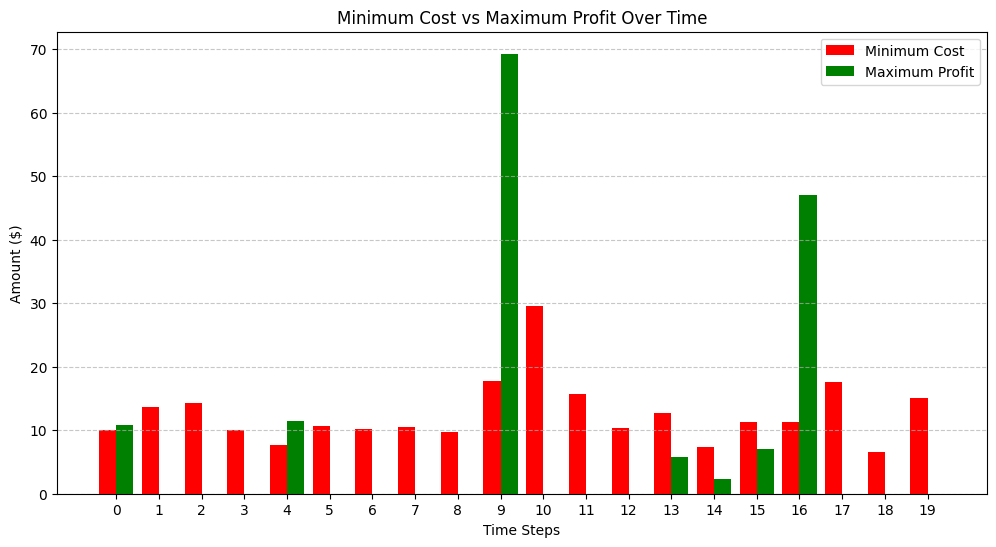

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Environment parameters
N = 3  # Smart Hospital, Telemedicine, Remote Surgery
T = 20  # Reduced for better visualization
slices = ['Smart Hospital', 'Telemedicine', 'Remote Surgery']

# U1 Formula (Total Cost Aggregation)
def compute_U1(S_fp, c_n_v, c_n_k, A_n_fk, c_ij):
    return np.sum(S_fp * (np.sum(c_n_v) + np.sum(c_n_k * A_n_fk))) + np.sum(c_ij)

# Neural Networks for MADDPG
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))  # Continuous action space

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Q-value

# Device configuration
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize agents
actors = [Actor(4, 1).to(dev) for _ in range(N)]
critics = [Critic(5).to(dev) for _ in range(N)]  # 4 state inputs + 1 action

actor_optimizers = [optim.Adam(actor.parameters(), lr=0.001) for actor in actors]
critic_optimizers = [optim.Adam(critic.parameters(), lr=0.002) for critic in critics]

# Initialize total cost, profit, and reward arrays
total_costs = np.zeros(T)
total_profits = np.zeros(T)
reward_values = np.zeros((N, T))  # Store rewards for each agent

gamma = 0.99  # Discount factor
tau = 0.01  # Soft update rate

def select_action(state, actor):
    state = torch.tensor(state, dtype=torch.float32).to(dev)
    with torch.no_grad():
        action = actor(state).cpu().numpy()
    return np.clip(action, 0, 1)  # Action within valid range

min_costs = np.full(T, np.inf)
max_profits = np.zeros(T)

for t in range(T):
    A_n = np.random.rand(N)  # Resource consumption
    M_n = np.random.rand(N)  # Price per unit resource
    C_l = np.random.rand(N)  # Link capacity
    M_l = np.random.rand(N)  # Price per unit link
    B_f = np.random.rand(N)  # QoS weight
    D_f = np.random.rand(N)  # Latency constraint
    H_f = np.random.rand(N)  # Reliability requirement
    A_demand = np.random.rand(N)  # Resource demand
    A_capacity = np.random.rand(N)  # Available capacity

    # U1 Computation Variables
    S_fp = np.random.randint(0, 2, size=(N, N))  # Binary service-path assignment
    c_n_v = np.random.rand(N)  # VNF creation cost
    c_n_k = np.random.rand(N)  # Computational cost per resource
    A_n_fk = np.random.rand(N)  # Allocated resources
    c_ij = np.random.rand(N)  # Communication cost per link

    U1 = compute_U1(S_fp, c_n_v, c_n_k, A_n_fk, c_ij)  # Compute total cost

    for i in range(N):
        state = [A_n[i], M_n[i], C_l[i], M_l[i]]
        action = select_action(state, actors[i])[0]  # Continuous action

        resource_cost = A_n[i] * M_n[i] + C_l[i] * M_l[i]
        qos_priority = B_f[i] * (1 / D_f[i] + H_f[i])
        dynamic_adjustment = 0.5 * (A_demand[i] / A_capacity[i])
        total_revenue = resource_cost + qos_priority + dynamic_adjustment
        reward = total_revenue - 1.2 * U1  # Using U1 in reward computation

        # Update total costs and profits
        total_costs[t] += U1
        total_profits[t] += (total_revenue - U1)
        min_costs[t] = min(min_costs[t], U1)
        max_profits[t] = max(max_profits[t], total_revenue - U1)

        # Store the reward for each agent
        reward_values[i, t] = reward

# Plot Minimum Cost vs Maximum Profit
x = np.arange(T)  # Time steps
plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, min_costs, width=0.4, label='Minimum Cost', color='red')
plt.bar(x + 0.2, max_profits, width=0.4, label='Maximum Profit', color='green')
plt.xlabel('Time Steps')
plt.ylabel('Amount ($)')
plt.title('Minimum Cost vs Maximum Profit Over Time')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


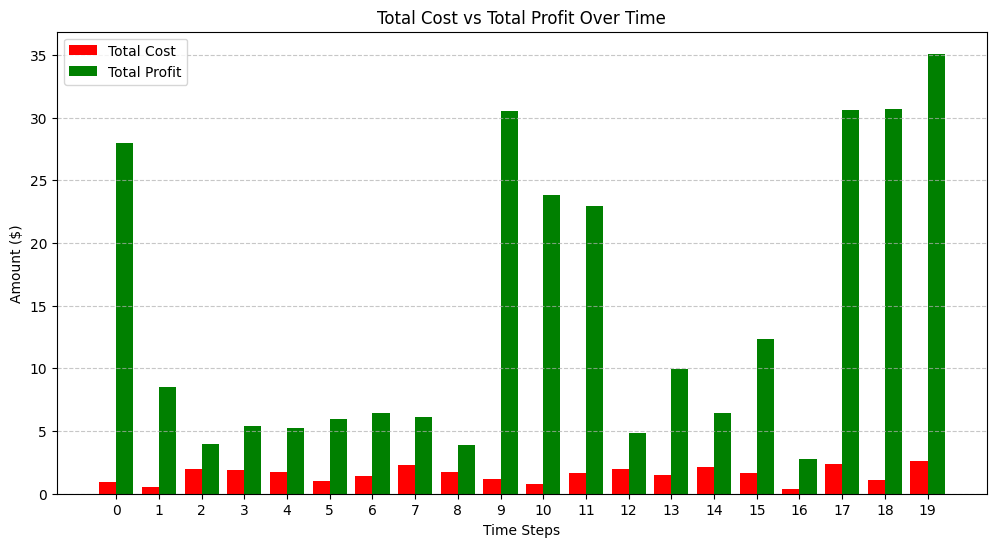

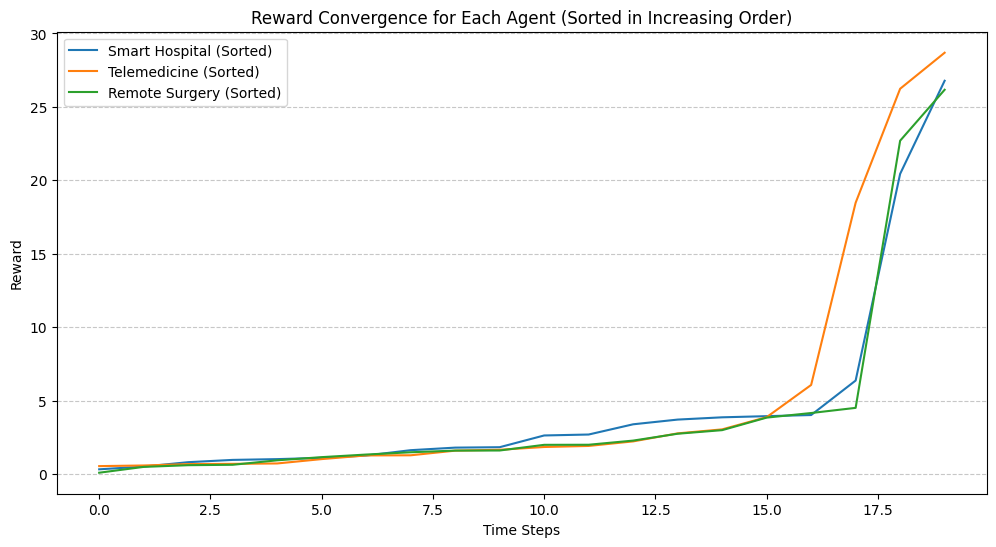

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Environment parameters
N = 3  # Smart Hospital, Telemedicine, Remote Surgery
T = 20  # Reduced for better visualization
slices = ['Smart Hospital', 'Telemedicine', 'Remote Surgery']

# Neural Networks for MADDPG
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))  # Continuous action space

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Q-value

# Device configuration
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize agents
actors = [Actor(4, 1).to(dev) for _ in range(N)]
critics = [Critic(5).to(dev) for _ in range(N)]  # 4 state inputs + 1 action

actor_optimizers = [optim.Adam(actor.parameters(), lr=0.001) for actor in actors]
critic_optimizers = [optim.Adam(critic.parameters(), lr=0.002) for critic in critics]

# Initialize total cost, profit, and reward arrays
total_costs = np.zeros(T)
total_profits = np.zeros(T)
reward_values = np.zeros((N, T))  # Store rewards for each agent

gamma = 0.99  # Discount factor
tau = 0.01  # Soft update rate

def select_action(state, actor):
    state = torch.tensor(state, dtype=torch.float32).to(dev)
    with torch.no_grad():
        action = actor(state).cpu().numpy()
    return np.clip(action, 0, 1)  # Action within valid range

for t in range(T):
    A_n = np.random.rand(N)  # Resource consumption
    M_n = np.random.rand(N)  # Price per unit resource
    C_l = np.random.rand(N)  # Link capacity
    M_l = np.random.rand(N)  # Price per unit link
    B_f = np.random.rand(N)  # QoS weight
    D_f = np.random.rand(N)  # Latency constraint
    H_f = np.random.rand(N)  # Reliability requirement
    A_demand = np.random.rand(N)  # Resource demand
    A_capacity = np.random.rand(N)  # Available capacity

    for i in range(N):
        state = [A_n[i], M_n[i], C_l[i], M_l[i]]
        action = select_action(state, actors[i])[0]  # Continuous action

        resource_cost = A_n[i] * M_n[i] + C_l[i] * M_l[i]
        qos_priority = B_f[i] * (1 / D_f[i] + H_f[i])
        dynamic_adjustment = 0.5 * (A_demand[i] / A_capacity[i])
        total_revenue = resource_cost + qos_priority + dynamic_adjustment
        reward = total_revenue - 1.2 * resource_cost  # Alpha = 1.2

        # Update total costs and profits
        total_costs[t] += resource_cost
        total_profits[t] += (total_revenue - resource_cost)

        # Store the reward for each agent
        reward_values[i, t] = reward

# Sort rewards in increasing order
sorted_rewards = np.sort(reward_values, axis=1)

# Plot Total Cost vs Total Profit as Bar Chart
x = np.arange(T)  # Time steps
plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, total_costs, width=0.4, label='Total Cost', color='red')
plt.bar(x + 0.2, total_profits, width=0.4, label='Total Profit', color='green')
plt.xlabel('Time Steps')
plt.ylabel('Amount ($)')
plt.title('Total Cost vs Total Profit Over Time')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot Reward Convergence for Each Agent in Increasing Order
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(sorted_rewards[i], label=f'{slices[i]} (Sorted)')
plt.xlabel('Time Steps')
plt.ylabel('Reward')
plt.title('Reward Convergence for Each Agent (Sorted in Increasing Order)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
